In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load participants data collected at 6 months follow up

In [2]:
df_hiv2 = pd.read_stata("../Data/DataAll/6months.dta")

print(df_hiv2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Columns: 292 entries, patid to minidiag1
dtypes: datetime64[ns](7), float32(7), float64(271), object(7)
memory usage: 2.4+ MB
None


Compute body mass index for the study participants

In [3]:
df_hiv2['heightst2'] /= 100  # Convert height to meters

# Calculate BMI and round to the nearest whole number
df_hiv2 = pd.concat([df_hiv2, (df_hiv2['weightst2'] / (df_hiv2['heightst2'] ** 2)).round().rename('BMI')], axis=1)

Duke Anxiety Depression Scale (DUKE-AD) 

In [4]:

Duke_items = ['dukeone', 'duketwo', 'dukethree', 'dukefour', 'dukefive']

# Compute Duke_score by summing across rows for the specified columns
Duke_score = df_hiv2[Duke_items].sum(axis=1)

# Concatenate Duke_score to df_hiv2 along the columns
df_hiv2 = pd.concat([df_hiv2, Duke_score.rename('Duke_score')], axis=1)

# Display the resulting DataFrame
print(df_hiv2[['patid', 'Duke_score']].head())


         patid  Duke_score
0  ED6/01/0001        25.0
1  ED6/01/0002        26.0
2  ED6/01/0003        25.0
3  ED6/01/0004        25.0
4  ED6/01/0005        24.0


COPE

In [5]:
rcope_col=['rcopeone','rcopetwo','rcopethree','rcopefour','rcopefive','rcopesix','rcopeseven','rcopeeight',
           'rcopenine','rcopeten','rcopeeleven','rcoptwelve','rcopethirteen','rcopeforteen']

#Compute Duke_score by summing across rows for the specified columns
COPE_score = df_hiv2[rcope_col].sum(axis=1)

# Concatenate Duke_score to df_hiv2 along the columns
df_hiv2 = pd.concat([df_hiv2, COPE_score.rename('COPE_score')], axis=1)

# Display the resulting DataFrame
print(df_hiv2[['patid', 'COPE_score']].head())

         patid  COPE_score
0  ED6/01/0001        42.0
1  ED6/01/0002        36.0
2  ED6/01/0003        43.0
3  ED6/01/0004        42.0
4  ED6/01/0005        50.0


HIV Clinical status

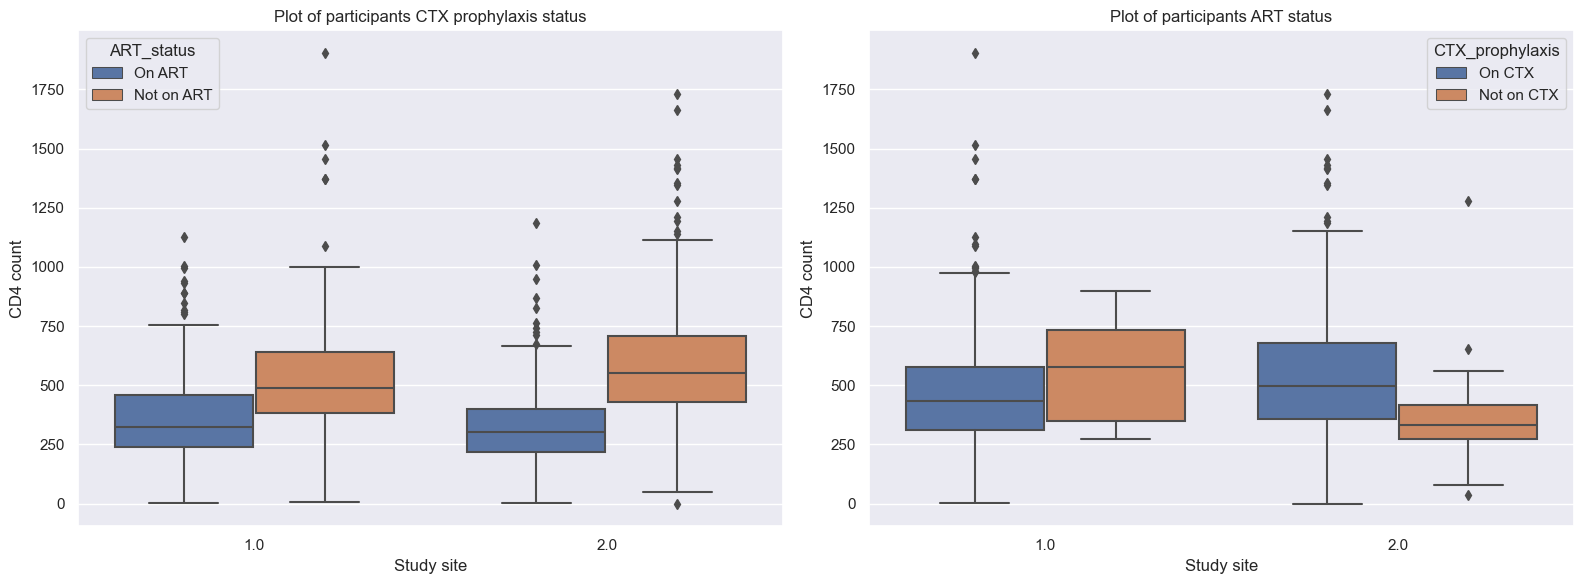

In [6]:
#make a copy of the df_hiv data frame 
df_hiv_copy= df_hiv2.copy()

# Map cotrimoxazole prophylaxis
CTX_mapping = {1: 'On CTX', 2: 'Not on CTX'}
df_hiv_copy['CTX_prophylaxis'] = df_hiv_copy['septin2'].map(CTX_mapping)

# Map hiv date values
ART_mapping = {1: 'On ART', 2: 'Not on ART'}
df_hiv_copy['ART_status'] = df_hiv_copy['arvs1'].map(ART_mapping)

#Exclude individuals with NaN in 'cd4' 
df_hiv_filtered = df_hiv_copy.dropna(subset=['cd4'])

# Set the style of seaborn
sns.set(style="darkgrid")

#Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
# Plot for 'cd4'
sns.boxplot(
    x='studsite',
    y='cd4',
    hue='ART_status',
    data=df_hiv_filtered,
    ax=axes[0]
)
axes[0].set_xlabel('Study site')
axes[0].set_ylabel('CD4 count')
axes[0].set_title('Plot of participants CTX prophylaxis status')

# Plot for 'cd4'
sns.boxplot(
    x='studsite',
    y='cd4',
    hue='CTX_prophylaxis',
    data=df_hiv_filtered,
    ax=axes[1]
)
axes[1].set_xlabel('Study site')
axes[1].set_ylabel('CD4 count')
axes[1].set_title('Plot of participants ART status')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
columns_to_convert = ['disrupt2', 'healthvisits2', 'hospdays2']

df_hiv2[columns_to_convert] = df_hiv2[columns_to_convert].apply(lambda x: (x > 0).astype(int))

Psyc_index = df_hiv2[columns_to_convert].sum(axis=1, skipna=True)

# Concatenate Duke_score to df_hiv2 along the columns
df_hiv2 = pd.concat([df_hiv2, Psyc_index.rename('PsycSocial_index')], axis=1)

Social Support

In [8]:
Soc_col = ['socneed2', 'socjoy2', 'socreal2', 'socemot2', 'soccomfo2', 'socfriend2',
           'socthing2', 'socprob2', 'socshare2', 'soclife2', 'socwill2', 'soctalk2']

# Compute SS_score without modifying the original DataFrame
SocSupport = pd.concat([df_hiv2[col].fillna(0) for col in Soc_col], axis=1).sum(axis=1) / len(Soc_col)

# Compute SS_cat without modifying the original DataFrame
SocSupport_cat = pd.cut(SocSupport,
               bins=[-float('inf'), 2.9, 5, float('inf')],
               labels=['Low', 'Moderate', 'High'],
               include_lowest=True)

# Concatenate the new Series to the original DataFrame
df_hiv2 = pd.concat([df_hiv2, SocSupport.rename('SocSupport'), SocSupport_cat.rename('SocSupport_cat')], axis=1)

Stress Score index

In [9]:
NE_col = ['father2', 'mother2', 'parentill2', 'parmisunder2', 'parneglect2', 'brother2',
                  'sister2', 'siblingill2', 'siblingmis2', 'siblingneg2', 'spouse2', 'lover2',
                  'spoloverill2', 'spolovmis2', 'spolovneg2', 'child2', 'childill2', 'childmis2',
                  'childcare2', 'ill2', 'anymis2', 'feelneg2', 'famprov2', 'jobloss2', 'discrim2',
                  'cope2', 'moneywor2']

# Create a subset DataFrame df_NE containing only the specified columns for negative life events
df_NE = df_hiv2[NE_col].copy()

# Calculate the number of negative life events (NE)for each participant  by summing across rows where the response is 1
Neg_Events = np.nansum(df_NE.values == 1, axis=1)

# Define custom cutoff points
custom_cutoffs = [-1,0, 3, 9, float('inf')]  # Adjusted for proper binning

# Create categories for study participants based on custom cutoff points
category_labels = ['None', '1-3', '4-9', '>=10']

# Create a temporary DataFrame for the first code chunk
df_temp_ne = pd.DataFrame({'Neg_Events': Neg_Events, 'NumNegEvents_cat': pd.cut(Neg_Events, bins=custom_cutoffs, labels=category_labels, include_lowest=True)})

# Display the resulting DataFrame and participant counts per category
#print(df_temp_ne.head())
print("\nThe number of Participants per Category:\n", df_temp_ne['NumNegEvents_cat'].value_counts())

# Concatenate the temporary DataFrames to the original DataFrame
df_hiv2 = pd.concat([df_hiv2, df_temp_ne], axis=1)


The number of Participants per Category:
 NumNegEvents_cat
1-3     473
4-9     318
None    242
>=10     56
Name: count, dtype: int64


In [10]:
# Create list_a and list_b as subsets of df_hiv

list_b = ['fathst2', 'mothst2', 'parst2', 'parmisst2', 'parnegst2', 'brost2',
                  'sisst2', 'siblingst2', 'sibmisst2', 'sibnegst2', 'spousest2', 'loverst2',
                  'spolovillst2', 'spolovmisst2', 'spolovnegst2', 'childst2', 'childillst2',
                  'childmisst2', 'childcarest2', 'illst2', 'anymisrest2', 'feelnegst2', 'famprovst2',
                  'joblossst2', 'discrimst2', 'copest2', 'moneyworst2']

# Create a subset DataFrame df_b containing only the columns from list_b_columns
df_b = df_hiv2[list_b].copy()

# Sum values in each row for selected columns, handling NaN values appropriately
row_sums = np.nansum(df_b.values, axis=1)

# Add the result as a new column "SSI" to df_hiv
df_hiv2['SSI'] = row_sums

StressScore=row_sums
# Convert 'SSI' into categorical variables based on custom cutoffs
custom_cutoffs = [-1, 0, 4, 9, float('inf')]
labels = ['None', '1-4', '5-9', '>=10']

# Create a temporary DataFrame for this code chunk
df_temp_ssi = pd.DataFrame({'StressScore': StressScore, 'StressScore_cat': pd.cut(StressScore, bins=custom_cutoffs, labels=labels, include_lowest=True)})

print("\nNumber of Participants per Category:\n", df_temp_ssi['StressScore_cat'].value_counts())

# Concatenate the temporary DataFrames to the original DataFrame
df_hiv2 = pd.concat([df_hiv2, df_temp_ssi], axis=1)


Number of Participants per Category:
 StressScore_cat
1-4     453
None    263
5-9     252
>=10    121
Name: count, dtype: int64


C:\Users\Mutema\AppData\Local\Temp\ipykernel_1032\3193928678.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hiv2['SSI'] = row_sums


## Sheehan's disability scale (SDS)
we computed sheehan's disability score(sds) for each study participant and created a new categorical variable based on the cut offs for severity.

In [11]:
# Calculate 'Sheehan's Disability Skscore' and 'SDS_cat'
SDS = df_hiv2[['dayslost', 'daysunproductive']].sum(axis=1, skipna=True, min_count=1)

# Define custom cutoff points for 'SDS_cat'
custom_cutoffs_sds = [-float('inf'), 0, 6, 12, float('inf')]
labels_sds = ["None","Low","Moderate","High"]

# Create a temporary DataFrame for 'SDS' and 'SDS_cat'
df_temp_sds = pd.DataFrame({'SDS': SDS, 'SDS_cat': pd.cut(SDS, bins=custom_cutoffs_sds, labels=labels_sds, include_lowest=True)})

# Concatenate the temporary DataFrame to the original DataFrame
df_hiv2 = pd.concat([df_hiv2, df_temp_sds], axis=1)

# Display the updated DataFrame
print(df_hiv2[['SDS','SDS_cat']].head())


   SDS   SDS_cat
0  0.0      None
1  7.0  Moderate
2  8.0  Moderate
3  7.0  Moderate
4  0.0      None


CES-D

In [12]:

df_hiv2['cscor2'] = pd.to_numeric(df_hiv2['cscor2'], errors='coerce')

# Update cscorcat based on the cutoff of 16
df_hiv2['cscorcat'] = np.select([np.isnan(df_hiv2['cscor2']), df_hiv2['cscor2'] >= 16], [0, 1], default=2)


C:\Users\Mutema\AppData\Local\Temp\ipykernel_1032\1280710020.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_hiv2['cscorcat'] = np.select([np.isnan(df_hiv2['cscor2']), df_hiv2['cscor2'] >= 16], [0, 1], default=2)


MINI plus for suicidality

In [ ]:
ms_columns = ['msacc2', 'mshurt2', 'mdie2', 'mshope2', 'msdead2', 'mswharm2', 'mssuic2', 'msplan2',
              'msstep2', 'msharm2', 'msattempt2', 'msresue2', 'msattdie2']

sublist_ms_columns = ['mshope2', 'msdead2', 'mswharm2', 'mssuic2', 'msplan2', 'msstep2', 'msharm2',
                      'msattempt2', 'msresue2', 'msattdie2']

# Set mhsdiag to 1 if any item in sublist_ms_columns is 1, otherwise set it to 2
df_hiv2['mhsdiag2'] = np.where(df_hiv2[sublist_ms_columns].eq(1).any(axis=1), 1, 2)

# Count the number of participants with a positive diagnosis of suicidality (mhsdiag=1)
count_mhsdiag = df_hiv2['mhsdiag2'].eq(1).sum()
print(f"\n There are {count_mhsdiag} participants with a positive diagnosis of suicidality")

sns.countplot(x='mhsdiag2', data=df_hiv2, palette='viridis')

# Only compute msseverity, handle NaN values, and categorize if mhsdiag is equal to 1
if 'mhsdiag2' in df_hiv2.columns:
    # Compute mhsseverity by summing selected columns where the response is 1
    df_hiv2['mhsseverity'] = df_hiv2[df_hiv2['mhsdiag2'] == 1][ms_columns].eq(1).sum(axis=1)

    # Handle NaN values in msseverity
    df_hiv2['mhsseverity'] = df_hiv2['mhsseverity'].fillna(0)
    
    # Define custom cutoffs for msseverity categories
    severity_cutoffs = [1, 8, 16, float('inf')]

    # Create categories for msseverity based on custom cutoff points
    df_hiv2['mhsseverity_cat'] = pd.cut(df_hiv2['mhsseverity'], bins=severity_cutoffs, labels=['Low', 'Moderate', 'High'], include_lowest=True)

    # Display the resulting DataFrame
    print(df_hiv2[['mhsdiag2', 'mhsseverity', 'mhsseverity_cat']].head())

    # Count the number of individuals in each msseverity category
    category_counts = df_hiv2['mhsseverity_cat'].value_counts()
    print("\nNumber of Participants per msseverity Category:\n", category_counts)
else:
    print("Column 'mhsdiag2' not found in the DataFrame.")


In [ ]:

# Create a countplot using seaborn
sns.countplot(x='mhsseverity_cat', data=df_hiv2, palette=sns.color_palette('colorblind'))

# Add labels and title
plt.ylabel('Number of study participants')
plt.xlabel('Severity of Suicidality')
plt.title('Number of study participants with a positive suicidality diagnosis')

# Display the plot
plt.show()


In [ ]:

#select columns to consider when computing severity of suicidality
ms_columns = ['msacc2', 'mshurt2', 'mdie2', 'mshope2', 'msdead2', 'mswharm2', 'mssuic2', 'msplan2',
              'msstep2', 'msharm2', 'msattempt2', 'msresue2', 'msattdie2']

# Replace values of 2 or NaN with 0 in the specified columns
df_hiv2[ms_columns] = df_hiv2[ms_columns].replace({2: 0, np.nan: 0})

# Compute msseverity only for rows where msdiag == 1, set others to NaN
df_hiv2['msserverity2'] = np.where(df_hiv2['msdiag2'] == 1, df_hiv2[ms_columns].sum(axis=1), np.nan)

# Define custom cutoffs for msseverity categories
severity_cutoffs = [1, 8, 16, float('inf')]

# Create categories for msseverity based on custom cutoff points
df_hiv2['msserverity_cat'] = pd.cut(df_hiv2['msserverity2'], 
                                    bins=severity_cutoffs, labels=['Low', 'Moderate', 'High'], include_lowest=True)

# Count the number of participants with a positive diagnosis of suicidality (msdiag=1)
count_msdiag = df_hiv2['msdiag2'].eq(1).sum()

# Display the resulting DataFrame and count of participants per category
print(df_hiv2[['msdiag2', 'msserverity2', 'msserverity_cat']].head())
print(f"\n There are {count_msdiag} participants with a positive diagnosis of suicidality")

# Count the number of participants per msseverity category
category_counts = df_hiv2['msserverity_cat'].value_counts()
print("\nNumber of Participants per msseverity Category:\n", category_counts)


In [ ]:
# Remove missing or constant columns from the data frame
df_hiv2 = df_hiv2.loc[:, df_hiv2.nunique() > 1]

df_hiv2.info(verbose=False)